# Model Pruning

**Module 03 | Notebook 3 of 5**

Pruning removes unnecessary weights from neural networks, making them smaller and faster.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand different pruning strategies
2. Apply L1 unstructured pruning with PyTorch
3. Visualize sparsity in neural networks
4. Analyze the accuracy vs. sparsity trade-off

---

### Prerequisites
- Basic PyTorch neural network knowledge
- Understanding of histograms and distributions

---

In [1]:
%%capture
# Install core libraries:
# - transformers: for model loading
# - torch: for pruning utilities
# - seaborn/matplotlib: for visualization
!pip install transformers torch matplotlib seaborn pandas

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## What is Pruning?

### The Intuition

Neural networks are often **over-parameterized**. Many weights contribute little to the output.

```
BEFORE PRUNING:                AFTER PRUNING (50%):
●━━━━━━●━━━━━━●                ●━━━━━━●━━━━━━●
 \    /|\    /                  \      |\    /
  \  / | \  /                    \     | \  /
   \/  |  \/                      \    |  \/
   /\  |  /\                       \   |  /\
  /  \ | /  \                       \  | /  \
 /    \|/    \                       \ |/    \
●━━━━━━●━━━━━━●                ●      ●      ●
 \    /|\    /                        |\    /
  \  / | \  /                         | \  /
   \/  |  \/                          |  \/
   /\  |  /\                          |  /\
  /  \ | /  \                         | /  \
 /    \|/    \                        |/    \
●━━━━━━●━━━━━━●                ●      ●      ●

All connections             Weak connections removed
```


### 🔍 Why Pruning Works: The Redundancy Hypothesis

Neural networks often exhibit **significant redundancy**. Many weights are extremely close to zero or correlated with others. 

> **The Lottery Ticket Hypothesis** suggests that dense networks contain sparse sub-networks (winning tickets) that can match the accuracy of the original network when trained in isolation.

By identifying and removing these "weak" connections (weights close to 0), we can reduce model size and potentially speed up inference without hurting accuracy too much.
### Types of Pruning

| Type | Description | Pros | Cons |
|------|-------------|------|------|
| **Unstructured** | Remove individual weights | Most flexible, highest sparsity | Irregular memory access |
| **Structured** | Remove entire neurons/channels | Hardware-friendly | Less flexible |
| **Magnitude-based** | Remove smallest weights | Simple, effective | May miss important small weights |
| **Gradient-based** | Remove by gradient importance | More accurate | Requires training data |

---

## Load and Analyze the Model

In [3]:
# Load a pre-trained model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Count parameters
# We check 'dim() >= 2' usually to focus on weight matrices rather than vectors/biases,
# but for parameter counting, we want all trainable params.
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    # Non-zero parameters are those that haven't been pruned (set to 0)
    nonzero = sum((p != 0).sum().item() for p in model.parameters())
    return total, nonzero

total, nonzero = count_parameters(model)
print(f"Model: {model_name}")
print(f"Total parameters: {total:,}")
print(f"Non-zero parameters: {nonzero:,}")
print(f"Sparsity: {(1 - nonzero/total)*100:.2f}%")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model: distilbert-base-uncased-finetuned-sst-2-english
Total parameters: 66,955,010
Non-zero parameters: 66,955,010
Sparsity: 0.00%


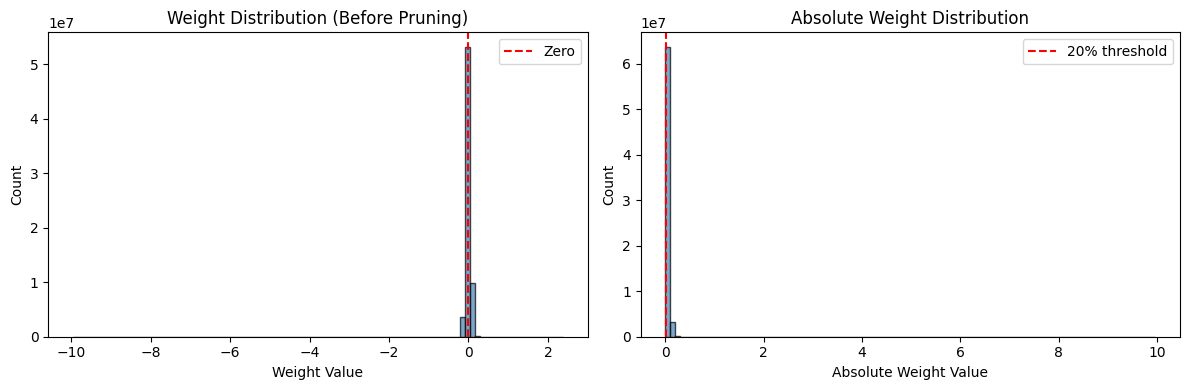


Weight statistics:
  Min: -9.9695
  Max: 2.3805
  Mean: -0.0134
  Std: 0.0481


In [4]:
# Visualize weight distribution before pruning
def get_all_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() >= 2:
            weights.extend(param.detach().cpu().flatten().numpy())
    return np.array(weights)

weights_before = get_all_weights(model)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(weights_before, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Weight Value')
plt.ylabel('Count')
plt.title('Weight Distribution (Before Pruning)')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.abs(weights_before), bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Absolute Weight Value')
plt.ylabel('Count')
plt.title('Absolute Weight Distribution')
plt.axvline(x=np.percentile(np.abs(weights_before), 20), color='red', linestyle='--', label='20% threshold')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nWeight statistics:")
print(f"  Min: {weights_before.min():.4f}")
print(f"  Max: {weights_before.max():.4f}")
print(f"  Mean: {weights_before.mean():.4f}")
print(f"  Std: {weights_before.std():.4f}")

### 📊 Interpretation: Weight Distribution

Observe the histogram above. You'll likely see a **bell-shaped curve (Gaussian)** centered around zero.
- Most weights are small (near 0).
- These small weights likely contribute less to the final output.
- **L1 Pruning** targets the values in the center peak of this distribution.

---

## Apply Unstructured Pruning

In [5]:
def apply_pruning(model, amount=0.3, prune_type='l1'):
    """
    Apply pruning to all Linear layers in the model.
    
    Args:
        model: PyTorch model
        amount: Fraction of parameters to prune (0-1). E.g. 0.3 = 30% of lowest weights.
        prune_type: 'l1' for magnitude-based, 'random' for random
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # prune.l1_unstructured replaces the 'weight' attribute with a masked version.
            # It creates 'weight_orig' (original) and 'weight_mask' (binary mask).
            if prune_type == 'l1':
                prune.l1_unstructured(module, name='weight', amount=amount)
            elif prune_type == 'random':
                prune.random_unstructured(module, name='weight', amount=amount)
    
    return model

def remove_pruning_reparametrization(model):
    """
    Make pruning permanent by removing the reparametrization.
    The 'weight' attribute becomes the final masked version (zeros are permanent).
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            try:
                prune.remove(module, 'weight')
            except:
                pass
    return model

In [6]:
# Create a copy for pruning
model_pruned = deepcopy(model)

# Apply 30% pruning
prune_amount = 0.3
model_pruned = apply_pruning(model_pruned, amount=prune_amount)

print(f"Applied {prune_amount*100:.0f}% L1 unstructured pruning")

Applied 30% L1 unstructured pruning


In [7]:
# Check sparsity after pruning
total, nonzero = count_parameters(model_pruned)
sparsity = (1 - nonzero/total) * 100

print(f"After pruning:")
print(f"  Total parameters: {total:,}")
print(f"  Non-zero parameters: {nonzero:,}")
print(f"  Sparsity: {sparsity:.2f}%")

After pruning:
  Total parameters: 66,955,010
  Non-zero parameters: 66,955,010
  Sparsity: 0.00%


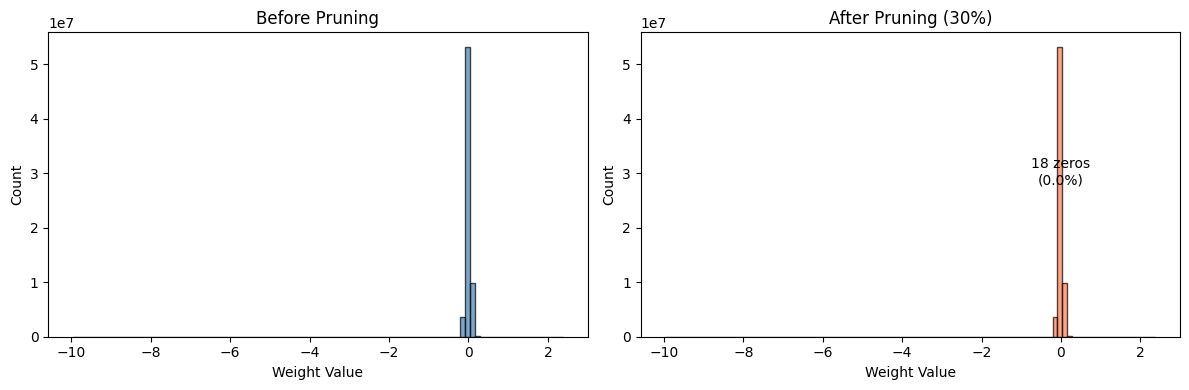

In [8]:
# Visualize weight distribution after pruning
weights_after = get_all_weights(model_pruned)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before
axes[0].hist(weights_before, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Weight Value')
axes[0].set_ylabel('Count')
axes[0].set_title('Before Pruning')

# After
axes[1].hist(weights_after, bins=100, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Weight Value')
axes[1].set_ylabel('Count')
axes[1].set_title(f'After Pruning ({prune_amount*100:.0f}%)')

# Add zero spike annotation
zero_count = (np.abs(weights_after) < 1e-8).sum()
axes[1].annotate(f'{zero_count:,} zeros\n({zero_count/len(weights_after)*100:.1f}%)', 
                 xy=(0, axes[1].get_ylim()[1]*0.5),
                 fontsize=10, ha='center')

plt.tight_layout()
plt.show()

---

## Visualize Sparsity per Layer

In [9]:
def get_layer_sparsity(model):
    """Calculate sparsity for each layer."""
    sparsity_data = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.data
            total = weight.numel()
            zeros = (weight == 0).sum().item()
            sparsity = zeros / total * 100
            
            sparsity_data.append({
                'Layer': name.split('.')[-2] + '.' + name.split('.')[-1] if '.' in name else name,
                'Total Params': total,
                'Zeros': zeros,
                'Sparsity (%)': sparsity
            })
    
    return pd.DataFrame(sparsity_data)

sparsity_df = get_layer_sparsity(model_pruned)
print("Layer-wise Sparsity:")
print(sparsity_df.to_string(index=False))

Layer-wise Sparsity:
            Layer  Total Params  Zeros  Sparsity (%)
  attention.q_lin        589824 176947     29.999966
  attention.k_lin        589824 176947     29.999966
  attention.v_lin        589824 176947     29.999966
attention.out_lin        589824 176947     29.999966
         ffn.lin1       2359296 707789     30.000008
         ffn.lin2       2359296 707789     30.000008
  attention.q_lin        589824 176947     29.999966
  attention.k_lin        589824 176947     29.999966
  attention.v_lin        589824 176947     29.999966
attention.out_lin        589824 176947     29.999966
         ffn.lin1       2359296 707789     30.000008
         ffn.lin2       2359296 707789     30.000008
  attention.q_lin        589824 176947     29.999966
  attention.k_lin        589824 176947     29.999966
  attention.v_lin        589824 176947     29.999966
attention.out_lin        589824 176947     29.999966
         ffn.lin1       2359296 707789     30.000008
         ffn.lin2       2

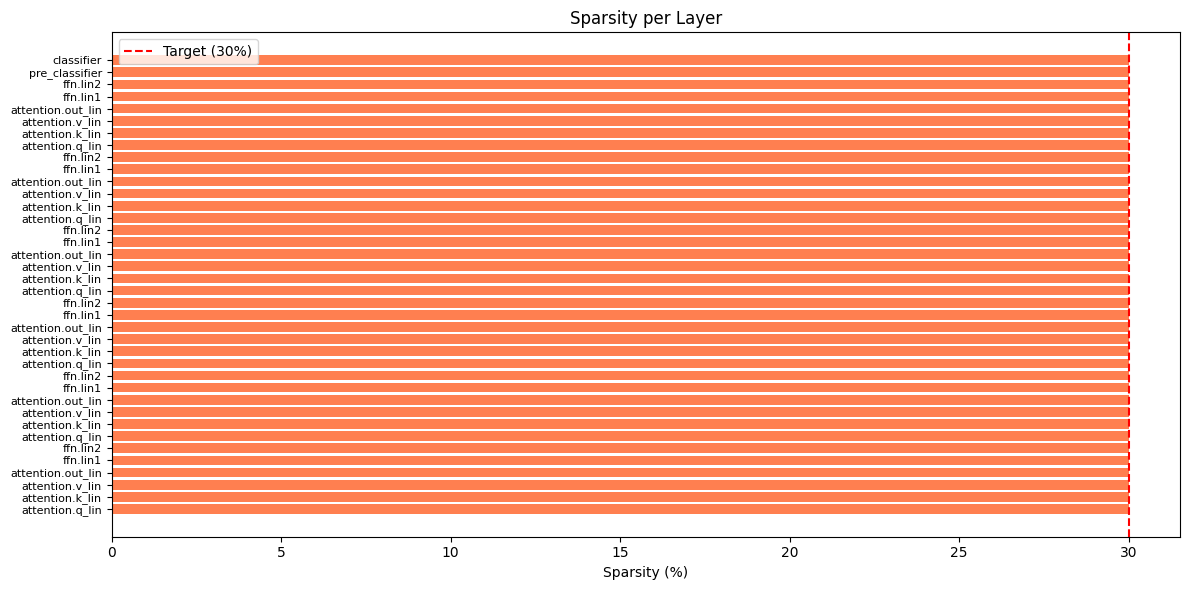

In [10]:
# Visualize sparsity per layer
plt.figure(figsize=(12, 6))
plt.barh(range(len(sparsity_df)), sparsity_df['Sparsity (%)'], color='coral')
plt.yticks(range(len(sparsity_df)), sparsity_df['Layer'], fontsize=8)
plt.xlabel('Sparsity (%)')
plt.title('Sparsity per Layer')
plt.axvline(x=30, color='red', linestyle='--', label='Target (30%)')
plt.legend()
plt.tight_layout()
plt.show()

---

## Evaluate Accuracy Impact

In [11]:
# Load test data
dataset = load_dataset("glue", "sst2")
test_data = dataset['validation'].shuffle(seed=42).select(range(500))

def evaluate_accuracy(model, tokenizer, test_data, device='cpu'):
    model = model.to(device)
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for example in test_data:
            inputs = tokenizer(
                example['sentence'],
                return_tensors='pt',
                truncation=True,
                max_length=128
            ).to(device)
            
            outputs = model(**inputs)
            pred = outputs.logits.argmax(dim=-1).item()
            
            if pred == example['label']:
                correct += 1
    
    return correct / len(test_data)

print("Evaluating models...")

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Evaluating models...


In [12]:
# Compare accuracy
acc_original = evaluate_accuracy(model, tokenizer, test_data, device)
acc_pruned = evaluate_accuracy(model_pruned, tokenizer, test_data, device)

print(f"\nAccuracy Comparison:")
print(f"  Original Model: {acc_original:.2%}")
print(f"  Pruned Model ({prune_amount*100:.0f}%): {acc_pruned:.2%}")
print(f"  Accuracy Drop: {(acc_original - acc_pruned)*100:.2f}%")


Accuracy Comparison:
  Original Model: 90.80%
  Pruned Model (30%): 89.60%
  Accuracy Drop: 1.20%


---

## Sparsity vs. Accuracy Trade-off

In [13]:
# Test different pruning levels
prune_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = []

print("Testing different pruning levels...")
for level in prune_levels:
    # Create fresh copy
    test_model = deepcopy(model)
    
    if level > 0:
        test_model = apply_pruning(test_model, amount=level)
    
    # Evaluate
    acc = evaluate_accuracy(test_model, tokenizer, test_data, device)
    total, nonzero = count_parameters(test_model)
    actual_sparsity = (1 - nonzero/total) * 100
    
    results.append({
        'Target Sparsity': level * 100,
        'Actual Sparsity': actual_sparsity,
        'Accuracy': acc * 100
    })
    
    print(f"  {level*100:.0f}% pruning → {acc:.2%} accuracy")
    
    del test_model

results_df = pd.DataFrame(results)

Testing different pruning levels...
  0% pruning → 90.80% accuracy
  10% pruning → 90.00% accuracy
  20% pruning → 89.60% accuracy
  30% pruning → 89.60% accuracy
  40% pruning → 89.40% accuracy
  50% pruning → 88.20% accuracy
  60% pruning → 83.20% accuracy
  70% pruning → 79.60% accuracy
  80% pruning → 76.40% accuracy


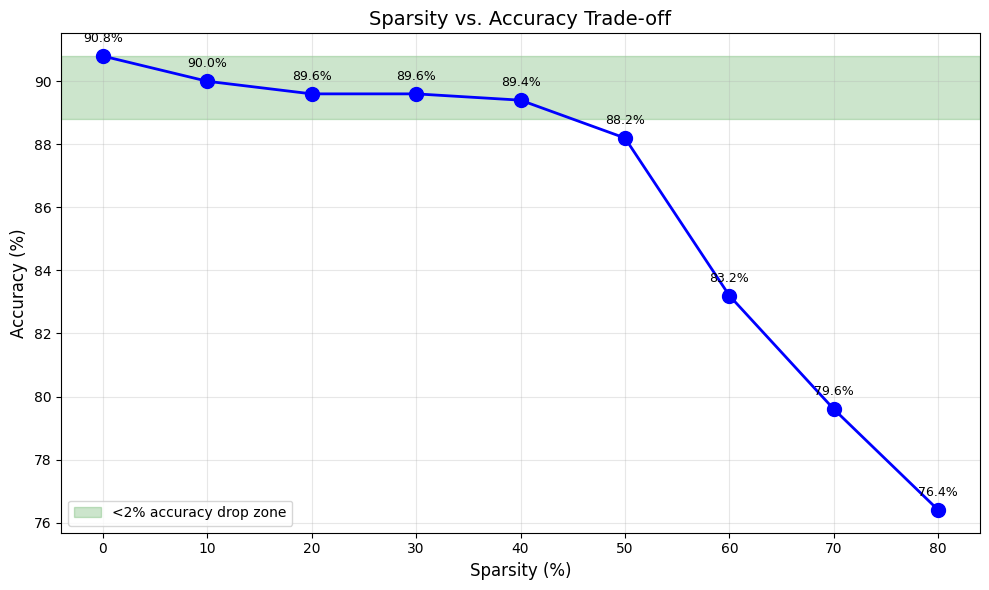


Results Summary:
 Target Sparsity  Actual Sparsity  Accuracy
             0.0              0.0      90.8
            10.0              0.0      90.0
            20.0              0.0      89.6
            30.0              0.0      89.6
            40.0              0.0      89.4
            50.0              0.0      88.2
            60.0              0.0      83.2
            70.0              0.0      79.6
            80.0              0.0      76.4


In [14]:
# Plot trade-off
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results_df['Target Sparsity'], results_df['Accuracy'], 'bo-', linewidth=2, markersize=10)

# Highlight "sweet spot"
ax.axhspan(results_df['Accuracy'].iloc[0] - 2, results_df['Accuracy'].iloc[0], 
           alpha=0.2, color='green', label='<2% accuracy drop zone')

ax.set_xlabel('Sparsity (%)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Sparsity vs. Accuracy Trade-off', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Annotate points
for _, row in results_df.iterrows():
    ax.annotate(f"{row['Accuracy']:.1f}%", 
                (row['Target Sparsity'], row['Accuracy']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nResults Summary:")
print(results_df.to_string(index=False))

---

## Making Pruning Permanent

In [15]:
# Remove pruning reparametrization to make it permanent
model_final = deepcopy(model_pruned)
model_final = remove_pruning_reparametrization(model_final)

# Verify
total, nonzero = count_parameters(model_final)
print(f"Final pruned model:")
print(f"  Total parameters: {total:,}")
print(f"  Non-zero parameters: {nonzero:,}")
print(f"  Sparsity: {(1 - nonzero/total)*100:.2f}%")

Final pruned model:
  Total parameters: 66,955,010
  Non-zero parameters: 54,037,406
  Sparsity: 19.29%


In [16]:
# Save the pruned model
save_path = "./pruned_model"
model_final.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nPruned model saved to {save_path}")


Pruned model saved to ./pruned_model


---

## 🎯 Student Challenge

### Challenge: Find Optimal Pruning Level

<details>
<summary><strong>💡 Hints & Trade-off Tips</strong></summary>

- **The "Sweet Spot"**: Often between 40% and 60% sparsity. Below this, accuracy stays stable. Above this, it drops efficiently.
- **Random vs. L1**: Random pruning usually performs worse because you might delete important, high-magnitude weights. L1 is "smarter" because it assumes small weights are less important.
- **Fine-tuning**: Pruning *after* training is called "Post-training Pruning". To reach very high sparsity (e.g., 90%), you typically need **Iterative Pruning** (Prune -> Retrain -> Prune -> Retrain).
</details>

In [17]:
# TODO: Find the maximum pruning level that keeps accuracy drop < 1%

# 1. Based on the results above, what is the sweet spot?
# 2. Try finer-grained pruning levels (e.g., 0.35, 0.40, 0.45)
# 3. What if you use random pruning instead of L1? Is L1 better?

# Your solution:


---

## Key Takeaways

1. **Pruning removes weights** based on importance (usually magnitude)
2. **Unstructured pruning** is flexible but may not speed up inference
3. **L1 pruning** removes smallest absolute values
4. **30-50% sparsity** often has minimal accuracy impact
5. **Trade-off exists** between sparsity and accuracy

---

## Next Steps

Continue to `04_quantization.ipynb` for precision reduction techniques!